/tmp/ipython-input-3-1906333811.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[timestamp_col] = pd.to_datetime(df[timestamp_col])


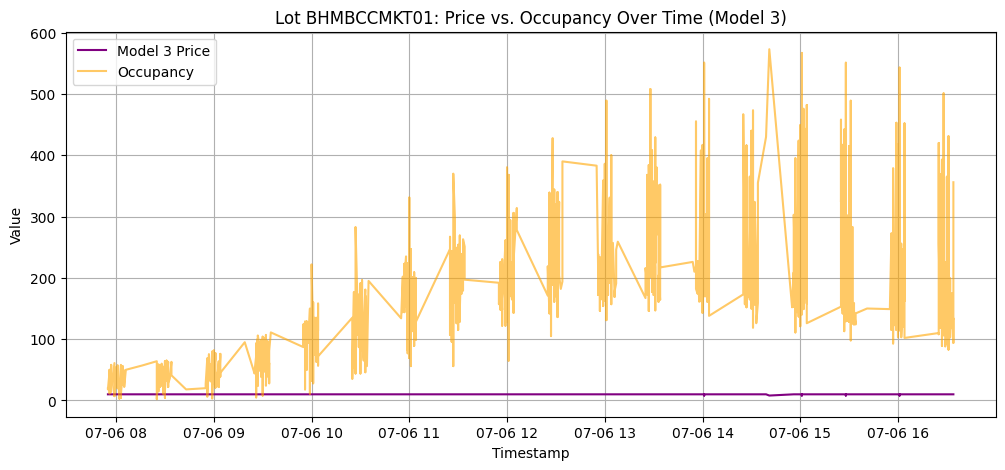


Model 3 (Competitive & Geo-aware) complete.



In [3]:
# Dynamic Pricing for Urban Parking Lots - Model 3 Only

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic

# === Load Data ===
if not os.path.exists("dataset.csv"):
    raise FileNotFoundError("dataset.csv not found. Please upload it to your runtime environment.")

df = pd.read_csv("dataset.csv")

# === Column Detection ===
timestamp_col = [col for col in df.columns if 'time' in col.lower()][0]
df[timestamp_col] = pd.to_datetime(df[timestamp_col])

lot_id_col = next((col for col in df.columns if col.lower() in ['lot_id', 'systemcodenumber', 'parkinglotid']), None)
occupancy_col = next((col for col in df.columns if col.lower() in ['occupancy', 'current_occupancy']), None)
capacity_col = next((col for col in df.columns if col.lower() in ['capacity', 'total_capacity']), None)
lat_col = next((col for col in df.columns if col.lower() in ['latitude', 'lat']), None)
lon_col = next((col for col in df.columns if col.lower() in ['longitude', 'lon', 'long']), None)

# === Model 3: Competitive Geo-Aware Pricing ===
def model3_competitive_price(df, base_price=10.0, influence_radius=0.5, competitor_discount=0.2):
    df = df.copy()
    df = df.sort_values(by=[lot_id_col, timestamp_col])
    df['price_model3'] = base_price

    lot_coords = {
        lot: (df[df[lot_id_col] == lot][lat_col].iloc[0], df[df[lot_id_col] == lot][lon_col].iloc[0])
        for lot in df[lot_id_col].unique()
    }

    prices = []
    for _, row in df.iterrows():
        lot = row[lot_id_col]
        price = base_price

        competitors = [lid for lid in lot_coords if lid != lot and geodesic(lot_coords[lot], lot_coords[lid]).km <= influence_radius]
        crowded = row[occupancy_col] >= 0.9 * row[capacity_col]

        if crowded and competitors:
            price *= (1 - competitor_discount)

        prices.append(round(price, 2))

    df['price_model3'] = prices
    return df

# === Run Model 3 ===
df_model3 = model3_competitive_price(df)

# === Plot Results ===
lot_id = df[lot_id_col].unique()[0]
df_lot3 = df_model3[df_model3[lot_id_col] == lot_id]

plt.figure(figsize=(12, 5))
plt.plot(df_lot3[timestamp_col], df_lot3['price_model3'], label='Model 3 Price', color='purple')
plt.plot(df_lot3[timestamp_col], df_lot3[occupancy_col], label='Occupancy', color='orange', alpha=0.6)
plt.title(f'Lot {lot_id}: Price vs. Occupancy Over Time (Model 3)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("\nModel 3 (Competitive & Geo-aware) complete.\n")